In [1]:
import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
import sunpy.map
import ndcube
import numpy as np
import matplotlib.pyplot as plt
import synthesizAR
from synthesizAR.models import semi_circular_loop, semi_circular_arcade
from synthesizAR.interfaces.ebtel import EbtelInterface,read_xml
from synthesizAR.instruments import InstrumentSDOAIA, InstrumentDEM
from synthesizAR.instruments.util import extend_celestial_wcs

# Multi-loop Models

A notebook that experiments with observables produced by loops evolving along a LOS for a few different scenarios:

- 1 event on one loop (impulsive low-frequency)
- N events on one loop (high frequency)
- 1 event per loop for N loops (impulsive, low-frequency)

The spacing between events in the second and third cases should be the same. The total energy released in all cases should be the same.

## Geometry

In [2]:
pov = SkyCoord(lon=0*u.deg, lat=0*u.deg, obstime='2023-02-22 00:00:00', frame='heliographic_stonyhurst')

In [3]:
strand = semi_circular_loop(100*u.Mm, observer=pov, n_points=50)

In [4]:
bundle = semi_circular_arcade(100*u.Mm, .5*u.deg, 20, observer=pov, gamma=0*u.deg, n_points=50)

We will set up three different skeletons.

In [5]:
skeleton_1 = synthesizAR.Skeleton([synthesizAR.Loop('strand_0', strand)])
skeleton_2 = synthesizAR.Skeleton(copy.deepcopy(skeleton_1.loops))
strands = [synthesizAR.Loop(f'strand_{i}', s) for i,s in enumerate(bundle)]
skeleton_3 = synthesizAR.Skeleton(strands)

In [6]:
observer = SkyCoord(lon=0*u.deg, lat=0*u.deg, radius=1*u.AU, frame=pov.frame)

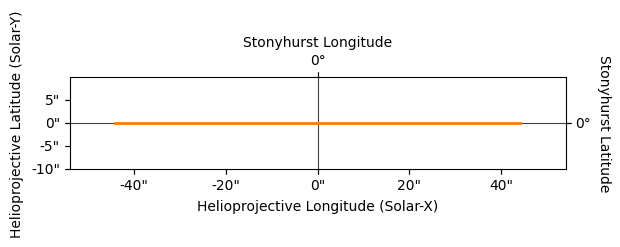

In [7]:
skeleton_1.peek(observer=observer, plot_kwargs={'color':'C1', 'lw':2})

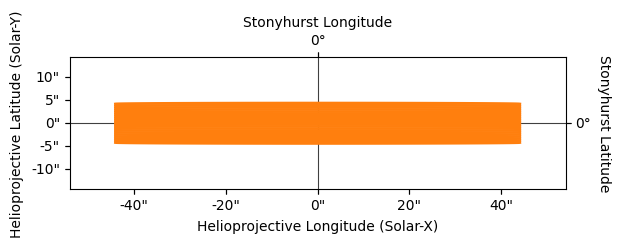

In [8]:
skeleton_3.peek(observer=observer,plot_kwargs={'color':'C1', 'lw':2})

## Hydrodynamics

In [9]:
class UniformHeating:
    """
    Uniform pulses with triangular profiles
    """
    
    def __init__(self,
                 energy_density: u.Unit('erg cm-3'),
                 duration: u.s, 
                 start_time: u.s,
                 wait_time: u.s,
                 number_events,
                 loop_offset=True):
        self.energy_density = energy_density
        self.duration = duration
        self.start_time = start_time
        self.wait_time = wait_time
        self.number_events = number_events
        self.loop_offset = loop_offset
    
    @property
    def heating_rate(self):
        return 2 * self.energy_density / (self.number_events * self.duration) * np.ones((self.number_events,))
    
    def calculate_event_properties(self, loop):
        # NOTE: this adds an offset in the time based on the loop number. This requires configuring
        # the loop name in a particular way (as I've done above)
        loop_num = int(loop.name.split('_')[1]) if self.loop_offset else 0 
        start_times = self.start_time + (self.duration + self.wait_time) * (loop_num + np.arange(self.number_events))
        end_times = start_times + duration
        return {
            'magnitude': self.heating_rate.to_value('erg cm-3 s-1'),
            'rise_start': start_times.to_value('s'),
            'rise_end': (start_times + self.duration/2).to_value('s'),
            'decay_start': (start_times + self.duration/2).to_value('s'),
            'decay_end': end_times.to_value('s'),
        }

In [10]:
ebtel_config = read_xml('/Users/wtbarnes/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')

In [11]:
ebtel_config

{'total_time': 5000.0,
 'tau': 1.0,
 'tau_max': 1e+300,
 'loop_length': 4000000000.0,
 'saturation_limit': 1.0,
 'force_single_fluid': False,
 'use_c1_loss_correction': True,
 'use_c1_grav_correction': True,
 'use_flux_limiting': False,
 'calculate_dem': False,
 'save_terms': False,
 'use_adaptive_solver': False,
 'output_filename': 'ebtel++_results_file.txt',
 'adaptive_solver_error': 1e-06,
 'adaptive_solver_safety': 0.5,
 'c1_cond0': 2.0,
 'c1_rad0': 0.6,
 'helium_to_hydrogen_ratio': 0.075,
 'surface_gravity': 1.0,
 'dem': OrderedDict([('use_new_method', True),
              ('temperature', {'bins': 451, 'log_min': 4, 'log_max': 8.5})]),
 'heating': OrderedDict([('background', 3.5e-05),
              ('partition', 1.0),
              ('events',
               [{'event': {'magnitude': 0.1,
                  'rise_start': 0.0,
                  'rise_end': 50.0,
                  'decay_start': 50.0,
                  'decay_end': 100.0}},
                {'event': {'magnitude': 0.15,

In [12]:
ebtel_directory = '/Users/wtbarnes/Documents/codes/ebtelPlusPlus/'

In [13]:
ebtel_config['total_time'] = 1.5e4
ebtel_config['use_flux_limiting'] = True
ebtel_config['saturation_limit'] = 1/6
ebtel_config['use_adaptive_solver'] = True

In [14]:
total_energy_density = 7.5*u.Unit('erg cm-3')
duration = 200*u.s
start_time = 500 * u.s

Configure first heating model--1 event on one loop (impulsive low-frequency)

In [15]:
heating = UniformHeating(total_energy_density, duration, 5000*u.s, 250*u.s, 1, loop_offset=False)
ebtel_1 = EbtelInterface(ebtel_config, heating, ebtel_directory)
skeleton_1.load_loop_simulations(ebtel_1)

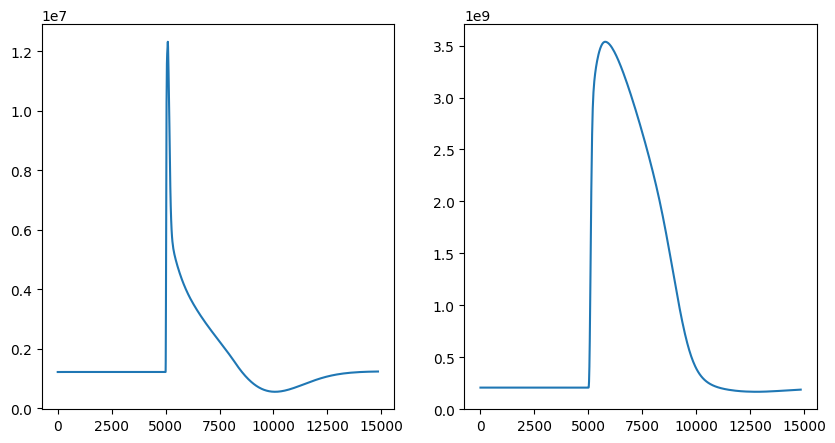

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for l in skeleton_1.loops:
    ax[0].plot(l.time, l.electron_temperature[:,0])
    ax[1].plot(l.time, l.density[:,0])

Configure second heating model--N events on one loop (high frequency)

In [17]:
heating = UniformHeating(total_energy_density, duration, start_time, 250*u.s, len(skeleton_3.loops), loop_offset=False)
ebtel_2 = EbtelInterface(ebtel_config, heating, ebtel_directory)
skeleton_2.load_loop_simulations(ebtel_2)

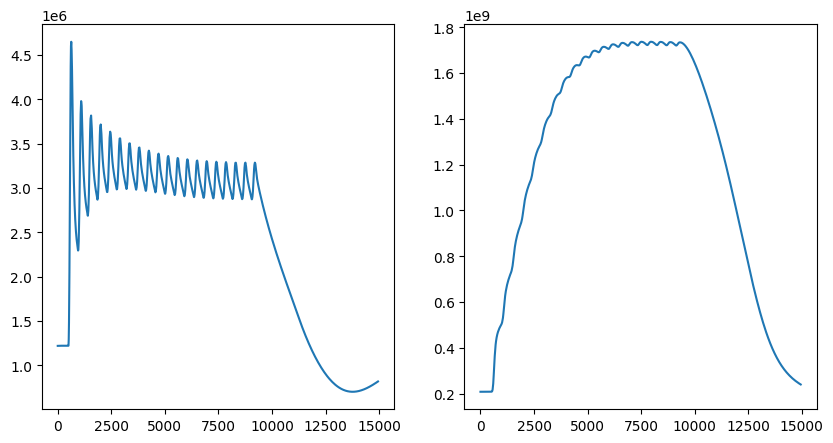

In [18]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for l in skeleton_2.loops:
    ax[0].plot(l.time, l.electron_temperature[:,0])
    ax[1].plot(l.time, l.density[:,0])

Configure third heating model--1 event per loop for N loops (impulsive, low-frequency)

In [19]:
heating = UniformHeating(total_energy_density/len(skeleton_3.loops), duration, start_time, 250*u.s, 1, loop_offset=True)
ebtel_3 = EbtelInterface(ebtel_config, heating, ebtel_directory)
skeleton_3.load_loop_simulations(ebtel_3)

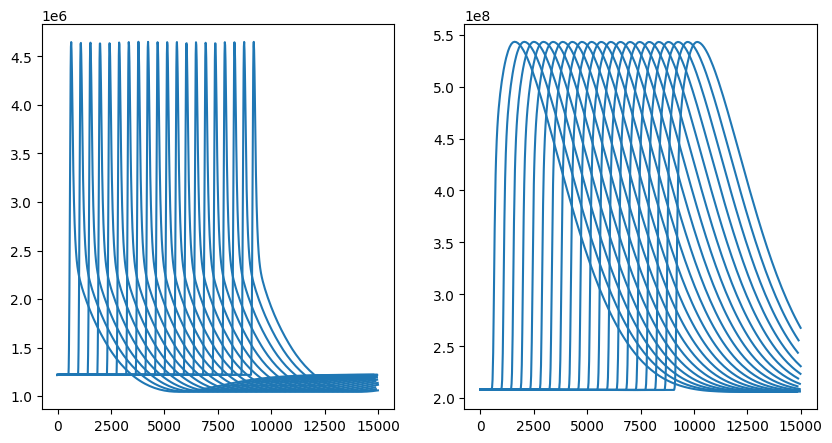

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
for l in skeleton_3.loops:
    ax[0].plot(l.time, l.electron_temperature[:,0], color='C0',)
    ax[1].plot(l.time, l.density[:,0], color='C0',)

Show a quick comparison between all three of these.

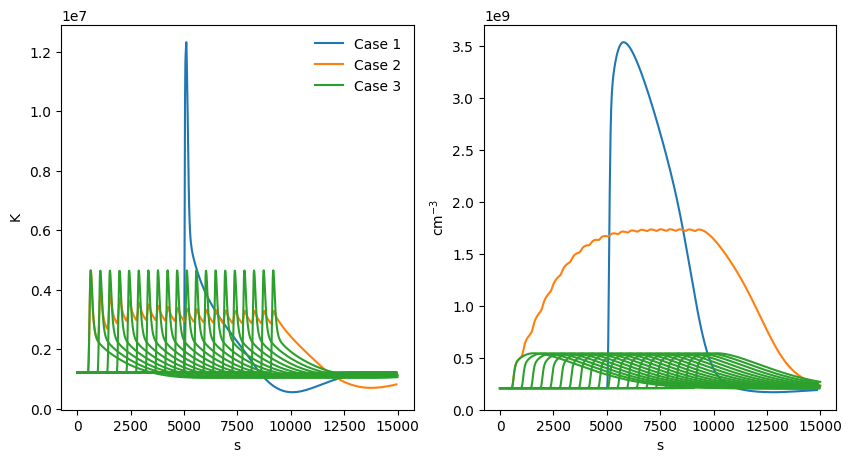

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
with quantity_support():
    ax[0].plot(skeleton_1.loops[0].time, skeleton_1.loops[0].electron_temperature[:,0], color='C0',label='Case 1')
    ax[1].plot(skeleton_1.loops[0].time, skeleton_1.loops[0].density[:,0], color='C0',)
    ax[0].plot(skeleton_2.loops[0].time, skeleton_2.loops[0].electron_temperature[:,0], color='C1',label='Case 2')
    ax[1].plot(skeleton_2.loops[0].time, skeleton_2.loops[0].density[:,0], color='C1',)
    for i,l in enumerate(skeleton_3.loops):
        ax[0].plot(l.time, l.electron_temperature[:,0], color='C2', label='Case 3' if i==0 else None)
        ax[1].plot(l.time, l.density[:,0], color='C2',)
    ax[0].legend(frameon=False)

## Instrument

In [22]:
aia = InstrumentSDOAIA(4900*u.s+[0,1]*u.h, observer, pad_fov=(5,5)*u.arcsec,)

In [23]:
aia_maps_1 = aia.observe(skeleton_1,  channels=aia.channels[:3])

In [24]:
aia_maps_2 = aia.observe(skeleton_2,  channels=aia.channels[:3])

In [25]:
aia_maps_3 = aia.observe(skeleton_3,  channels=aia.channels[:3])

In [26]:
def map_dict_to_ndcollection(map_dict, time):
    cubes = []
    for k in map_dict:
        map_seq = sunpy.map.Map(map_dict[k], sequence=True)
        data = np.array([m.data for m in map_seq])
        wcs = extend_celestial_wcs(map_seq[0].wcs, time, 'time', 'time')
        cube = ndcube.NDCube(data, wcs=wcs, unit=map_seq[0].unit, meta=map_seq[0].meta,)
        cubes.append((k, cube))
    return ndcube.NDCollection(cubes, aligned_axes=(0,1,2))

In [27]:
aia_collection_1 = map_dict_to_ndcollection(aia_maps_1, aia.observing_time)
aia_collection_2 = map_dict_to_ndcollection(aia_maps_2, aia.observing_time)
aia_collection_3 = map_dict_to_ndcollection(aia_maps_3, aia.observing_time)

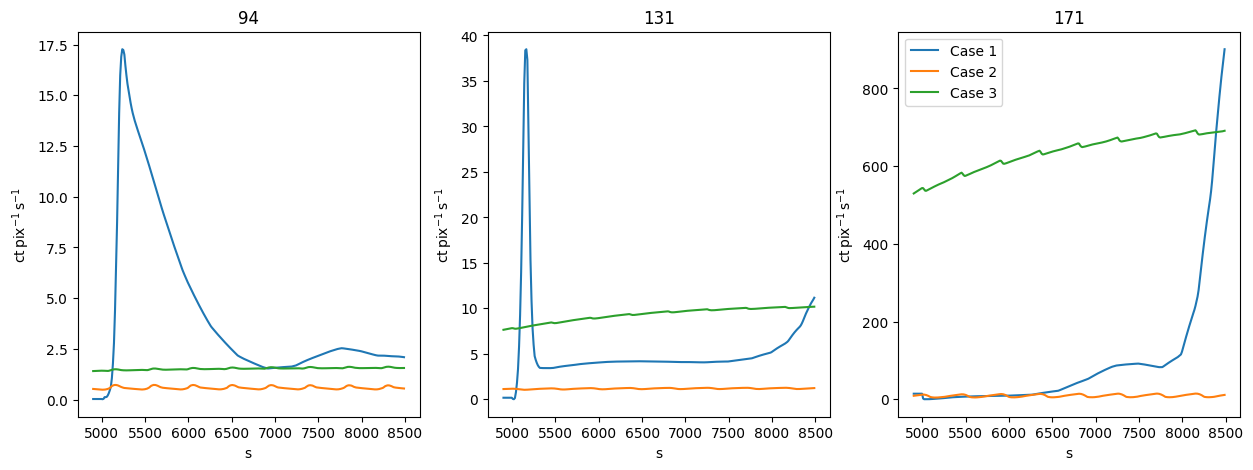

In [28]:
fig = plt.figure(figsize=(15,5))
with quantity_support():
    for i,k in enumerate(['94','131','171']):
        ax = fig.add_subplot(1,3,i+1)
        ax.set_title(k)
        ax.plot(aia_collection_1[k].axis_world_coords(0)[0], aia_collection_1[k].data.sum(axis=(1,2))*aia_collection_1[k].unit, label='Case 1')
        ax.plot(aia_collection_2[k].axis_world_coords(0)[0], aia_collection_2[k].data.sum(axis=(1,2))*aia_collection_2[k].unit, label='Case 2')
        ax.plot(aia_collection_3[k].axis_world_coords(0)[0], aia_collection_3[k].data.sum(axis=(1,2))*aia_collection_3[k].unit, label='Case 3')
ax.legend()

Now, compute the DEM but in this case, make the resolution much lower

In [29]:
class InstrumentDEMCoarse(InstrumentDEM):
    
    @property
    @u.quantity_input
    def resolution(self) -> u.arcsec / u.pix:
        return (50,50)*u.arcsec / u.pix

In [30]:
dem_instr = InstrumentDEMCoarse(aia.observing_time,
                          observer,
                          temperature_bin_edges=10**np.arange(5.5, 7.6, 0.1)*u.K,
                          fov_center=SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=aia.projected_frame),
                          fov_width=(100,50)*u.arcsec,)

In [31]:
dem_maps_1 = dem_instr.observe(skeleton_1)

In [32]:
dem_maps_2 = dem_instr.observe(skeleton_2)

In [33]:
dem_maps_3 = dem_instr.observe(skeleton_3)

In [34]:
dem_collection_1 = map_dict_to_ndcollection(dem_maps_1, dem_instr.observing_time)
dem_collection_2 = map_dict_to_ndcollection(dem_maps_2, dem_instr.observing_time)
dem_collection_3 = map_dict_to_ndcollection(dem_maps_3, dem_instr.observing_time)

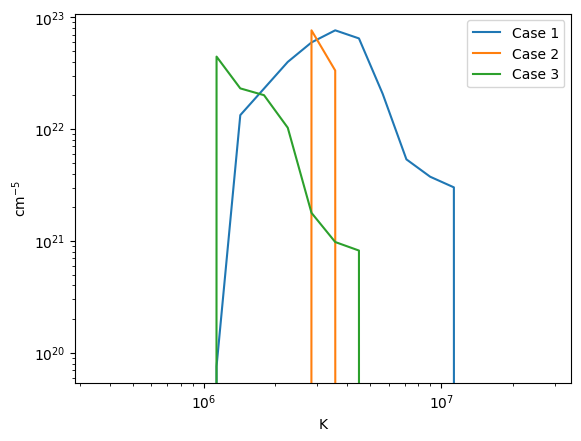

In [35]:
with quantity_support():
    for i,col in enumerate([dem_collection_1, dem_collection_2, dem_collection_3]):
        dem_1d = u.Quantity([col[c].data.mean(axis=0)[0,0] for c in col], col['5.50-5.60'].unit)
        plt.plot(dem_instr.temperature_bin_centers, dem_1d, label=f'Case {i+1}')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()